## Dependencies

In [ ]:
# Standard library imports
import os  # For interacting with the operating system (e.g., setting environment variables, managing files)
import sys  # For system-specific parameters and functions
import cv2  # OpenCV for image processing
import shutil  # For file operations like copying and deleting
import random  # For generating random numbers
import warnings  # To manage warning messages

# Numerical and data manipulation libraries
import numpy as np  # For numerical operations and handling arrays
import pandas as pd  # For data manipulation and analysis
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For plotting graphs and visualizations

# TensorFlow and Keras for deep learning
from tensorflow import set_random_seed  # To set a random seed for reproducibility
from sklearn.utils import class_weight  # For handling class imbalances
from sklearn.model_selection import train_test_split  # To split the dataset into training and validation sets
from sklearn.metrics import confusion_matrix, cohen_kappa_score  # For model evaluation

# Keras modules for building and training neural networks
from keras import backend as K  # Access to backend operations (TensorFlow in this case)
from keras.models import Model  # To define deep learning models
from keras.utils import to_categorical  # Converts labels to one-hot encoding format
from keras import optimizers, applications  # Optimizers for training, pre-trained models from Keras Applications
from keras.preprocessing.image import ImageDataGenerator  # To augment image datasets
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input  # Layers for constructing the model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler  # Training callbacks

# To access files in Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Function to ensure reproducibility by setting a fixed random seed
def seed_everything(seed=0):
    random.seed(seed)  # Set seed for Python's built-in random module
    os.environ['PYTHONHASHSEED'] = str(seed)  # Fix hash-based operations for consistency
    np.random.seed(seed)  # Set seed for NumPy random operations
    set_random_seed(0)  # Set seed for TensorFlow random operations

# Set the global seed for the entire script
seed = 0
seed_everything(seed)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Configure Seaborn for plots
sns.set(style="whitegrid")

# Suppress warnings to reduce unnecessary output clutter
warnings.filterwarnings("ignore")

# Add EfficientNet implementation path to system path
sys.path.append("/content/efficientnet-master/")

# Import the EfficientNet model
from efficientnet import *

## Load data

In [ ]:
# Load data from CSV files containing the dataset and the fold information
fold_set = pd.read_csv('../input/aptos-data-split/5-fold.csv')

# Filter the training set from the fold data
X_train = fold_set[fold_set['fold_0'] == 'train']

# Filter the validation set from the fold data
X_val = fold_set[fold_set['fold_0'] == 'validation']

# Load the test set data
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# Print the number of samples in the training, validation, and test sets
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocess data by appending the '.png' file extension to the image IDs
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")

# Display the first few rows of the training set to verify the data format
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


id_code  diagnosis  height  width fold_0      fold_1      fold_2  \
0  000c1434d8d7.png          2    2136   3216  train       train       train   
1  001639a390f0.png          4    2136   3216  train       train  validation   
2  0024cdab0c1e.png          1    1736   2416  train       train       train   
3  002c21358ce6.png          0    1050   1050  train       train       train   
4  005b95c28852.png          0    1536   2048  train  validation       train   

       fold_3      fold_4  
0       train  validation  
1       train       train  
2       train  validation  
3  validation       train  
4       train       train

# Model parameters

In [ ]:
# Model parameters
# Batch size for training; defines the number of samples processed before the model is updated
BATCH_SIZE = 8

# Number of epochs for training; defines how many times the entire dataset will be passed through the model
EPOCHS = 20

# Number of warmup epochs; defines initial training phase before the main learning rate is applied
WARMUP_EPOCHS = 5

# Learning rate for the optimizer; controls how much to adjust the model weights during training
LEARNING_RATE = 1e-4

# Learning rate during the warmup phase; usually higher to help stabilize the model initially
WARMUP_LEARNING_RATE = 1e-3

# Height and width of the input images; standardizes input dimensions for the model
HEIGHT = 456
WIDTH = 456

# Number of channels in the input images; typically 3 for RGB images
CHANNELS = 3

# Patience for early stopping; number of epochs with no improvement before training is stopped
ES_PATIENCE = 5

# Patience for reducing learning rate on plateau; number of epochs with no improvement before reducing the learning rate
RLROP_PATIENCE = 3

# Drop factor for learning rate decay; controls the reduction of the learning rate
DECAY_DROP = 0.5

# Number of epochs for the first learning rate warmup; duration for gradually increasing the learning rate
LR_WARMUP_EPOCHS_1st = 2

# Number of epochs for the second learning rate warmup; additional duration for gradually increasing the learning rate
LR_WARMUP_EPOCHS_2nd = 5

# Step size for the number of training steps per epoch; calculated based on the total number of training samples and batch size
STEP_SIZE = len(X_train) // BATCH_SIZE

# Total steps for the first training phase (warmup); calculated as warmup epochs multiplied by step size
TOTAL_STEPS_1st = WARMUP_EPOCHS * STEP_SIZE

# Total steps for the entire training process; calculated as total epochs multiplied by step size
TOTAL_STEPS_2nd = EPOCHS * STEP_SIZE

# Total warmup steps for the first phase; calculated as first warmup epochs multiplied by step size
WARMUP_STEPS_1st = LR_WARMUP_EPOCHS_1st * STEP_SIZE

# Total warmup steps for the second phase; calculated as second warmup epochs multiplied by step size
WARMUP_STEPS_2nd = LR_WARMUP_EPOCHS_2nd * STEP_SIZE

# Pre-process images

In [ ]:
# Define base paths for the training and test image directories
train_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'

# Define destination paths for processed training, validation, and test images
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Ensure destination directories don't exist before creating new ones
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)  # Remove existing training directory if it exists
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)  # Remove existing validation directory if it exists
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)  # Remove existing test directory if it exists

# Create new directories for training, validation, and test images
os.makedirs(train_dest_path)  # Create training images directory
os.makedirs(validation_dest_path)  # Create validation images directory
os.makedirs(test_dest_path)  # Create test images directory

# Function to crop the image based on a tolerance level
def crop_image(img, tol=7):
    if img.ndim == 2:  # If the image is grayscale
        mask = img > tol  # Create a mask based on the tolerance
        return img[np.ix_(mask.any(1), mask.any(0))]  # Crop the image using the mask
    elif img.ndim == 3:  # If the image is colored
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert the image to grayscale
        mask = gray_img > tol  # Create a mask based on the tolerance
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):  # If the image is too dark and all pixels are cropped
            return img  # Return the original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]  # Crop each channel using the mask
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)  # Stack the channels back together
            
        return img  # Return the cropped image

# Function to crop the image into a circular shape
def circle_crop(img):
    img = crop_image(img)  # Crop the image first

    height, width, depth = img.shape  # Get the dimensions of the image
    largest_side = np.max((height, width))  # Determine the largest dimension for resizing
    img = cv2.resize(img, (largest_side, largest_side))  # Resize the image to a square

    height, width, depth = img.shape  # Update dimensions after resizing

    x = width // 2  # Calculate the center x-coordinate
    y = height // 2  # Calculate the center y-coordinate
    r = np.amin((x, y))  # Determine the radius for the circle

    circle_img = np.zeros((height, width), np.uint8)  # Create a blank mask
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)  # Draw a filled circle on the mask
    img = cv2.bitwise_and(img, img, mask=circle_img)  # Apply the circular mask to the image
    img = crop_image(img)  # Crop the image again to remove any surrounding areas

    return img  # Return the circularly cropped image

# Function to preprocess a single image: read, crop, resize, and save
def preprocess_image(base_path, save_path, image_id, HEIGHT, WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)  # Read the image from the base path
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB format
    image = circle_crop(image)  # Crop the image into a circular shape
    image = cv2.resize(image, (HEIGHT, WIDTH))  # Resize the image to the specified height and width
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)  # Enhance the image contrast
    cv2.imwrite(save_path + image_id, image)  # Save the processed image to the destination path
    
# Preprocess training set images
for i, image_id in enumerate(X_train['id_code']):
    preprocess_image(train_base_path, train_dest_path, image_id, HEIGHT, WIDTH)  # Process each training image
    
# Preprocess validation set images
for i, image_id in enumerate(X_val['id_code']):
    preprocess_image(train_base_path, validation_dest_path, image_id, HEIGHT, WIDTH)  # Process each validation image
    
# Preprocess test set images
for i, image_id in enumerate(test['id_code']):
    preprocess_image(test_base_path, test_dest_path, image_id, HEIGHT, WIDTH)  # Process each test image

# Data generator

In [ ]:
# This section sets up a way to enhance training images by making small changes to them, 
# like rotating or flipping, which helps the model learn better.
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

# This creates a generator for the training data, which will load images and their labels.
# It will apply the augmentations we defined earlier.
train_generator=datagen.flow_from_dataframe(
                          dataframe=X_train,
                          directory=train_dest_path,
                          x_col="id_code",
                          y_col="diagnosis",
                          class_mode="raw",
                          batch_size=BATCH_SIZE,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

# This sets up a generator for the validation data, which helps us see how well our model is doing.
valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)
# This creates a generator for the test data, which we will use to make predictions. 
# It does not require labels because we're only interested in the outputs.
test_generator=datagen.flow_from_dataframe(  
                          dataframe=test,
                          directory=test_dest_path,
                          x_col="id_code",
                          batch_size=1,
                          class_mode=None,
                          shuffle=False,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 1928 validated image filenames.


# Learning Rate Scheduler

In [ ]:
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """
    This function defines a learning rate schedule that gradually increases the learning rate during a warmup period,
    and then decreases it according to a cosine function for the remainder of the training.

    :param global_step {int}: The current training step.
    :param learning_rate_base {float}: The maximum learning rate to be used after warmup.
    :param total_steps {int}: The total number of training steps.
    :param warmup_learning_rate {float}: The initial learning rate during the warmup phase. (default: {0.0}).
    :param warmup_steps {int}: The number of steps for the warmup phase. (default: {0}).
    :param hold_base_rate_steps {int}: The number of steps to maintain the base learning rate before starting to decay. (default: {0}).
    :Returns: A float representing the current learning rate.
    :Raises ValueError: If warmup_learning_rate is greater than learning_rate_base, or if warmup_steps exceed total_steps.
    """

    # Check if the total steps are sufficient for the warmup steps
    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')

    # Calculate the learning rate based on cosine decay
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))

    # Maintain the base learning rate for the specified number of steps before decaying
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)

    # Apply warmup learning rate if applicable
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)

    # Set learning rate to 0 if global step exceeds total steps
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(Callback):
    """This class implements a learning rate scheduler that combines warmup and cosine decay."""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """
        Initializes the learning rate scheduler with parameters for the base learning rate, 
        total training steps, and warmup settings.

        :param learning_rate_base {float}: The maximum learning rate to be used after warmup.
        :param total_steps {int}: The total number of training steps.
        :param global_step_init {int}: The initial training step, typically from a previous checkpoint.
        :param warmup_learning_rate {float}: The initial learning rate during the warmup phase. (default: {0.0}).
        :param warmup_steps {int}: The number of steps for the warmup phase. (default: {0}).
        :param hold_base_rate_steps {int}: The number of steps to maintain the base learning rate before starting to decay. (default: {0}).
        :param verbose {int}: Controls the verbosity of the output; 1 will provide updates. (default: {0}).
        """

        # Initialize the parent class
        super(WarmUpCosineDecayScheduler, self).__init__()

        # Store the parameters
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []  # List to store learning rates for tracking

    def on_batch_end(self, batch, logs=None):
        """This method is called at the end of each batch to update the global step and log the learning rate."""
        self.global_step += 1  # Increment the global step
        lr = K.get_value(self.model.optimizer.lr)  # Get the current learning rate
        self.learning_rates.append(lr)  # Store the learning rate for tracking

    def on_batch_begin(self, batch, logs=None):
        """This method is called at the beginning of each batch to set the learning rate according to the schedule."""
        # Calculate the new learning rate based on the current global step
        lr = cosine_decay_with_warmup(
            global_step=self.global_step,
            learning_rate_base=self.learning_rate_base,
            total_steps=self.total_steps,
            warmup_learning_rate=self.warmup_learning_rate,
            warmup_steps=self.warmup_steps,
            hold_base_rate_steps=self.hold_base_rate_steps
        )
        
        # Update the optimizer's learning rate
        K.set_value(self.model.optimizer.lr, lr)
        
        # Optionally print the current learning rate
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

# Model

In [ ]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor) # Using the EfficientNetB5 architecture
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5') #Using the weights that come from training the model on the ImageNet Dataset. Available online.

    x = GlobalAveragePooling2D()(base_model.output) # Applies Global Average Pooling to the output of the EfficientNet model. Helps to reduce overfitting.
    final_output = Dense(1, activation='linear', name='final_output')(x) # Final output layer of the model
    model = Model(input_tensor, final_output) # Constructing the model using the input and final output layer. This model can now be trained with data.
    
    return model

# Train top layers

In [ ]:
# Create a new model with the specified input shape (height, width, and channels):
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

# Make all layers in the model non-trainable (fixed) for now, so they won't change during training:
for layer in model.layers:
    layer.trainable = False

# Unfreeze (make trainable) the last two layers of the model so they can be updated during training:
for i in range(-2, 0):
    model.layers[i].trainable = True

# Set up a learning rate schedule that increases the learning rate at the beginning and then decreases it:
cosine_lr_1st = WarmUpCosineDecayScheduler(
    learning_rate_base=WARMUP_LEARNING_RATE,  # The starting learning rate after warm-up.
    total_steps=TOTAL_STEPS_1st,  # The total number of training steps we will take.
    warmup_learning_rate=0.0,  # The learning rate at the start of the warm-up period.
    warmup_steps=WARMUP_STEPS_1st,  # How many steps to increase the learning rate.
    hold_base_rate_steps=(2 * STEP_SIZE)  # How many steps to keep the learning rate steady before decreasing.
)

# Define the metrics we want to track during training and set up the callback for the learning rate:
metric_list = ["accuracy"]  # We want to track how accurate our model is.
callback_list = [cosine_lr_1st]  # Use the learning rate schedule as a tool during training.

# Prepare the model for training by selecting an optimizer and loss function:
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)  # Use the Adam optimizer with the starting learning rate.
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)  # Compile the model to get it ready for training.

# Show a summary of the model's structure, including all the layers and their parameters:
model.summary()  # This prints out details about the model's architecture.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 228, 228, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 228, 228, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [ ]:
# Training the model, getting metrics such as accuracy and loss, for further analysis after the training process.
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     callbacks=callback_list,
                                     verbose=2).history

Epoch 1/5
 - 197s - loss: 2.1933 - acc: 0.4266 - val_loss: 1.8416 - val_acc: 0.4354
Epoch 2/5
 - 180s - loss: 1.0842 - acc: 0.4768 - val_loss: 1.4128 - val_acc: 0.4359
Epoch 3/5
 - 180s - loss: 0.8839 - acc: 0.4624 - val_loss: 2.2015 - val_acc: 0.3738
Epoch 4/5
 - 180s - loss: 0.8402 - acc: 0.4980 - val_loss: 2.3870 - val_acc: 0.3448
Epoch 5/5
 - 181s - loss: 0.7477 - acc: 0.5099 - val_loss: 2.0211 - val_acc: 0.4124


# Fine-tune the complete model

In [ ]:
# Make all layers of the model trainable, so they can learn from the data.
for layer in model.layers:
    layer.trainable = True

# Set up early stopping to monitor validation loss. 
# If it doesn't improve for a certain number of epochs (patience), training will stop.
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

# Initialize a learning rate scheduler that will adjust the learning rate 
# during training, starting with a warm-up phase.
cosine_lr_2nd = WarmUpCosineDecayScheduler(learning_rate_base=LEARNING_RATE,
                                           total_steps=TOTAL_STEPS_2nd,
                                           warmup_learning_rate=0.0,
                                           warmup_steps=WARMUP_STEPS_2nd,
                                           hold_base_rate_steps=(3 * STEP_SIZE))

# Combine the early stopping and learning rate scheduler into a list of callbacks.
callback_list = [es, cosine_lr_2nd]

# Use the Adam optimizer with the specified learning rate to compile the model.
optimizer = optimizers.Adam(lr=LEARNING_RATE)

# Compile the model with the optimizer, specify the loss function (mean squared error), 
# and metrics to track during training.
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)

# Print a summary of the model architecture, showing each layer and its details.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 228, 228, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 228, 228, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [ ]:
# Train the model using a generator to provide training data
history = model.fit_generator(generator=train_generator,  # Use the training data generator
                              steps_per_epoch=STEP_SIZE_TRAIN,  # How many batches to run in one training cycle
                              validation_data=valid_generator,  # Use the validation data generator to check performance
                              validation_steps=STEP_SIZE_VALID,  # How many validation batches to process
                              epochs=EPOCHS,  # Total number of times to go through the training data
                              callbacks=callback_list,  # Extra functions to run during training (like stopping early)
                              verbose=2).history  # Print progress information during training

Epoch 1/20
 - 420s - loss: 0.7286 - acc: 0.5116 - val_loss: 0.5090 - val_acc: 0.6441
Epoch 2/20
 - 376s - loss: 0.6346 - acc: 0.5352 - val_loss: 0.4123 - val_acc: 0.6745
Epoch 3/20
 - 375s - loss: 0.5860 - acc: 0.5529 - val_loss: 0.3977 - val_acc: 0.6966
Epoch 4/20
 - 375s - loss: 0.5300 - acc: 0.5854 - val_loss: 0.3666 - val_acc: 0.7117
Epoch 5/20
 - 375s - loss: 0.4584 - acc: 0.6291 - val_loss: 0.4086 - val_acc: 0.7117
Epoch 6/20
 - 376s - loss: 0.4072 - acc: 0.6721 - val_loss: 0.3409 - val_acc: 0.7710
Epoch 7/20
 - 376s - loss: 0.3570 - acc: 0.7059 - val_loss: 0.3128 - val_acc: 0.7697
Epoch 8/20
 - 375s - loss: 0.3050 - acc: 0.7387 - val_loss: 0.2792 - val_acc: 0.7586
Epoch 9/20
 - 374s - loss: 0.3082 - acc: 0.7322 - val_loss: 0.3421 - val_acc: 0.7241
Epoch 10/20
 - 375s - loss: 0.2743 - acc: 0.7633 - val_loss: 0.2614 - val_acc: 0.7890
Epoch 11/20
 - 374s - loss: 0.2566 - acc: 0.7684 - val_loss: 0.3538 - val_acc: 0.7683
Epoch 12/20
 - 374s - loss: 0.2448 - acc: 0.7787 - val_loss: 0.

# Visualization of Learning Rates

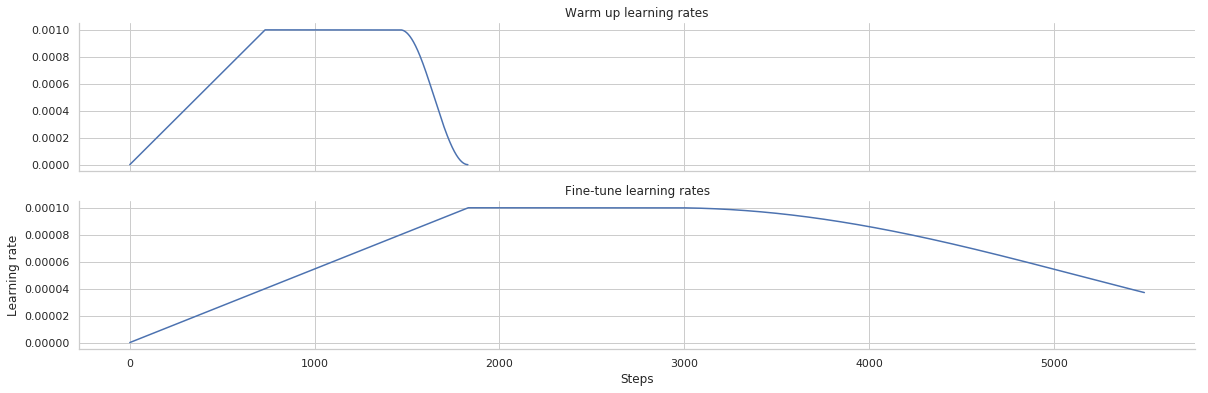

In [12]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 6))

ax1.plot(cosine_lr_1st.learning_rates)
ax1.set_title('Warm up learning rates')

ax2.plot(cosine_lr_2nd.learning_rates)
ax2.set_title('Fine-tune learning rates')

plt.xlabel('Steps')
plt.ylabel('Learning rate')
sns.despine()
plt.show()

# Model Training and Validation Loss and Accuracy

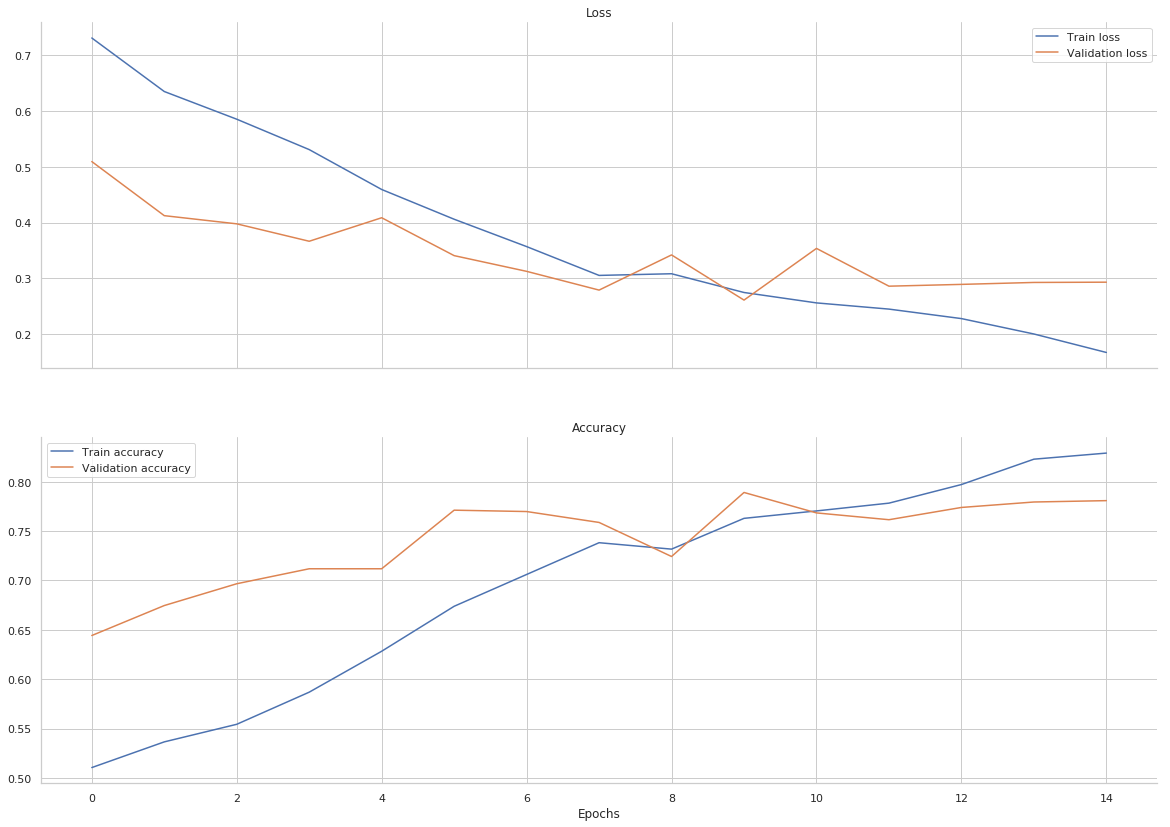

In [13]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Gathering Predictions and Labels

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

In [15]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

## Confusion Matrix

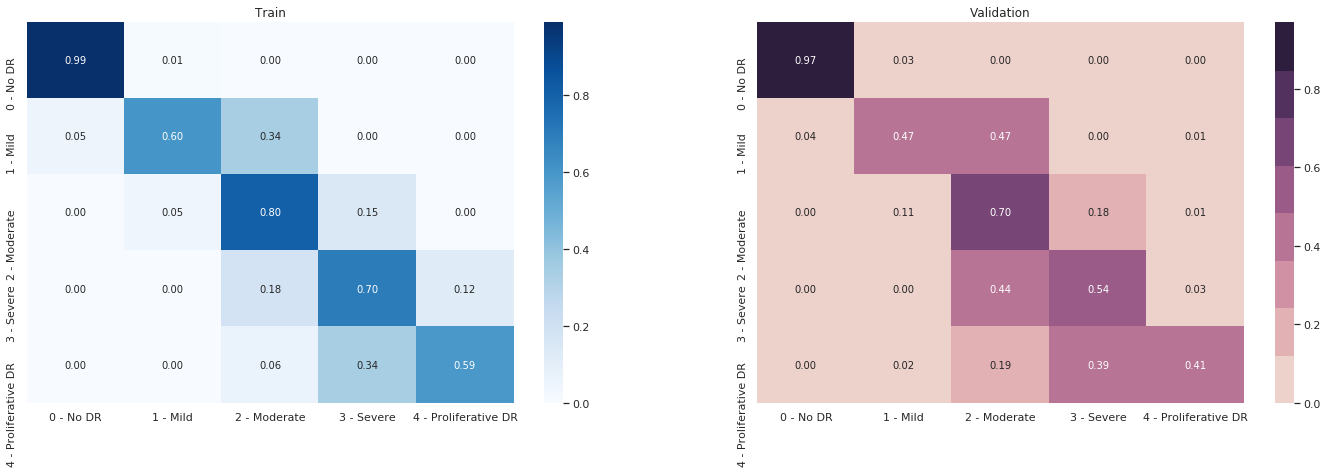

In [16]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

## Quadratic Weighted Kappa

In [17]:
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))
    
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

Train        Cohen Kappa score: 0.951
Validation   Cohen Kappa score: 0.907
Complete set Cohen Kappa score: 0.943


## Apply model to test set and output predictions

In [ ]:
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    # Loop through the specified number of TTA steps
    for i in range(steps): 
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)     # Calculate the average of predictions from all TTA steps

preds = apply_tta(model, test_generator) # Apply Test-Time Augmentation (TTA) to get predictions from the model
predictions = [classify(x) for x in preds] # Classify the predictions using the previously defined classify function

# Create a DataFrame to store the results with patient IDs and their corresponding diagnoses
results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

In [19]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

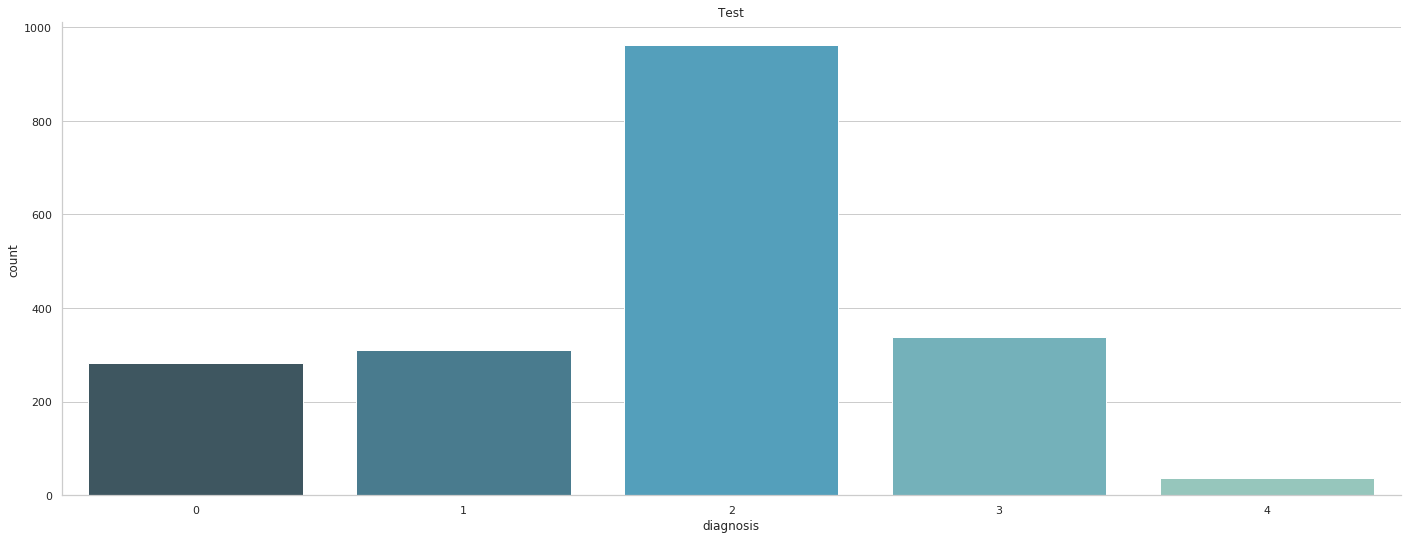

In [20]:
fig = plt.subplots(sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d").set_title('Test')
sns.despine()
plt.show()

## Save model

In [ ]:
# Saving the model weights to Google Drive for future use and averaging into the final model
weights_path = '/content/drive/My Drive/effNetB5_reg_img456_fold1.h5'
model.save_weights(weights_path)